In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from utils.utils_train import train_supervised, train_models_in_threads, test_model
from utils.utils_plots import plot_first_feature
from utils.utils_dataset import balance_dataset, prepare_dataset
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc
#%load_ext line_profiler

In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)

# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to normalize - all except 'Class'
cols_to_normalize = [col for col in data.columns if col != 'Class']

# Apply the normalization
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])


In [4]:
print(f"{torch.cuda.is_available()}")
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

False


In [5]:
# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 3,
    "kappa_join": 0.9,
    "S_0": 1e-10,
    "N_r": 8,
    "c_max": 100,
    "num_samples": 200,
    "device": device
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 3,
    "kappa_join": 0.9,
    "S_0": 1e-10,
    "N_r": 8,
    "c_max": 100,
    "num_samples": 200,
    "device": device
}

In [6]:

#display_dataset_split(client_train, test_data)
#plot_dataset_split(client_train, test_data)

In [7]:

import cProfile
%load_ext line_profiler


#plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  



In [8]:
if False:
       data, labels = client_train[0]
       model = local_models[0]

       %lprun -f model.forward\
              -f model.merging_mech.compute_kappa_matrix \
              -f model.merging_mech.merging_mechanism \
              -f model.merging_mech.update_merging_condition \
              -f model.merging_mech.compute_merging_condition\
              -f model.merging_mech.perform_merge\
              train_supervised(model, client_train[0])

In [9]:
def compare_models(model1, model2):
    differences = []

    # Function to find differing indices within the overlapping range
    def find_differing_indices(tensor1, tensor2):
        min_length = min(tensor1.size(0), tensor2.size(0))
        differing = (tensor1[:min_length] != tensor2[:min_length]).nonzero(as_tuple=False)
        if differing.nelement() == 0:
            return "No differences"
        else:
            return differing.view(-1).tolist()  # Flatten and convert to list

    # Compare mu parameter and find differing indices
    mu_equal = torch.equal(model1.mu[:model1.c], model2.mu[:model2.c])
    if not mu_equal:
        differing_indices_mu = find_differing_indices(model1.mu[:model1.c], model2.mu[:model2.c])
        differences.append(f"mu parameter differs at indices {differing_indices_mu}")

    # Compare S parameter and find differing indices
    S_equal = torch.equal(model1.S[:model1.c], model2.S[:model2.c])
    if not S_equal:
        differing_indices_S = find_differing_indices(model1.S[:model1.c], model2.S[:model2.c])
        differences.append(f"S parameter differs at indices {differing_indices_S}")

    # Compare n parameter and find differing indices
    n_equal = torch.equal(model1.n[:model1.c], model2.n[:model2.c])
    if not n_equal:
        differing_indices_n = find_differing_indices(model1.n[:model1.c], model2.n[:model2.c])
        differences.append(f"n parameter differs at indices {differing_indices_n}")

    # Check if there are any differences
    if differences:
        difference_str = ", ".join(differences)
        return False, f"Differences found in: {difference_str}"
    else:
        return True, "Models are identical"


In [10]:
import torch.nn as nn

def run_experiment(num_clients, num_rounds, clients_data, test_data):
        
    # Initialize a model for each client
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    # Initialize a list to store the metrics for each round
    round_metrics = []

    if False:
        # Assuming models and client_data are already defined
        #for client_idx, client_model in enumerate(local_models)
        model = local_models[0]
        pr = cProfile.Profile()
        pr.enable()
        train_supervised(model, client_train[0])
        pr.disable()
        pr.print_stats(sort='cumtime')

    for round in range(num_rounds):
        print(f"--- Communication Round {round + 1} ---")

        aggregated_model = eGAUSSp(**federated_model_params)
        federated_model = eGAUSSp(**federated_model_params)

        # Train local models
        #train_models_in_threads(local_models, clients_data)
        for local_model, client_data in zip(local_models, clients_data):
            train_supervised(local_model, client_data)

            all_scores, pred_max, _ = test_model(local_model, test_data)
            binary = calculate_metrics(pred_max, test_data, "binary")
            roc_auc = calculate_roc_auc(all_scores, test_data)
            print(f"Test Metrics: {binary}")
            print(f"Test ROC AUC: {roc_auc}")
            plot_confusion_matrix(pred_max, test_data)

        # Update federated model with local models
        for client_idx, client_model in enumerate(local_models):
            #client_model.federal_agent.federated_merging()
            print(f"Updating agreggated model with client {client_idx + 1}")

            aggregated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)
            print(f"Number of agreggated clusters after transfer = {sum(aggregated_model.n[0:aggregated_model.c]> aggregated_model.kappa_n)}")
            aggregated_model.federal_agent.federated_merging()
            print(f"Number of federated clusters after merging = {sum(aggregated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

            
                   
        #client_model.score = 0*client_model.score  
        #aggregated_model.S_glo = client_model.S_glo
        #aggregated_model.mu_glo = client_model.mu_glo     


        if round>1:
            with torch.no_grad():
                aggregated_model.S = nn.Parameter(aggregated_model.S/2)
                aggregated_model.n = nn.Parameter(aggregated_model.n/2)

                aggregated_model.S_glo = aggregated_model.S_glo/2
                aggregated_model.n_glo = aggregated_model.n_glo/2

        # New code for comparison using the updated compare_models function
        #are_models_same, comparison_message = compare_models(client_model, aggregated_model)
        #print(f"Comparison details: {comparison_message}")

        # Update federated model with local models
        print(f"Updating federated model with agreggated model")
        federated_model = aggregated_model #.federal_agent.merge_model_privately(aggregated_model, federated_model.kappa_n)
        print(f"Number of federated clusters after transfer = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")

 
        # Perform federated merging and removal mechanism on the federated model
        if any(federated_model.n[0:federated_model.c]> federated_model.kappa_n):

            # Evaluate federated model
            all_scores_fed, pred_max_fed, _ = test_model(federated_model, test_data)
            binary_fed = calculate_metrics(pred_max_fed, test_data, "binary")
            roc_auc_fed = calculate_roc_auc(all_scores_fed, test_data)
            print(f"Test Metrics: {binary_fed}")
            print(f"Test ROC AUC: {roc_auc_fed}")

            plot_confusion_matrix(pred_max_fed, test_data)

            # Append metrics to the list
            round_metrics.append({
                'round': round + 1,
                'clusters': federated_model.c,
                'binary': binary_fed,
                'roc_auc': roc_auc_fed
            })
            
        local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]  
        # Return the updated federated model to each client
        for client_idx in range(len(local_models)):
            print(f"Returning updated model to client {client_idx + 1}")
            #local_models[client_idx] = federated_model
            
            local_models[client_idx].federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
            #local_models[client_idx].score = torch.zeros_like(local_models[client_idx].score)

            '''
            # Return the updated federated model to each client
            for client_idx, client_model in enumerate(local_models):
                print(f"Returning updated model to client {client_idx + 1}")
                client_model.federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
                client_model.federal_agent.federated_merging()
            '''
            
        print(f"--- End of Round {round + 1} ---\n")
        if  round == (num_rounds-1):
            plot_first_feature(test_data, model=federated_model, num_sigma=2, N_max = federated_model.kappa_n)   
    
    # After all rounds
    print("All Rounds Completed. Metrics Collected:")
    for metric in round_metrics:
        print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
        #print(f"                         Weighted: {metric['weighted']}")


    return round_metrics

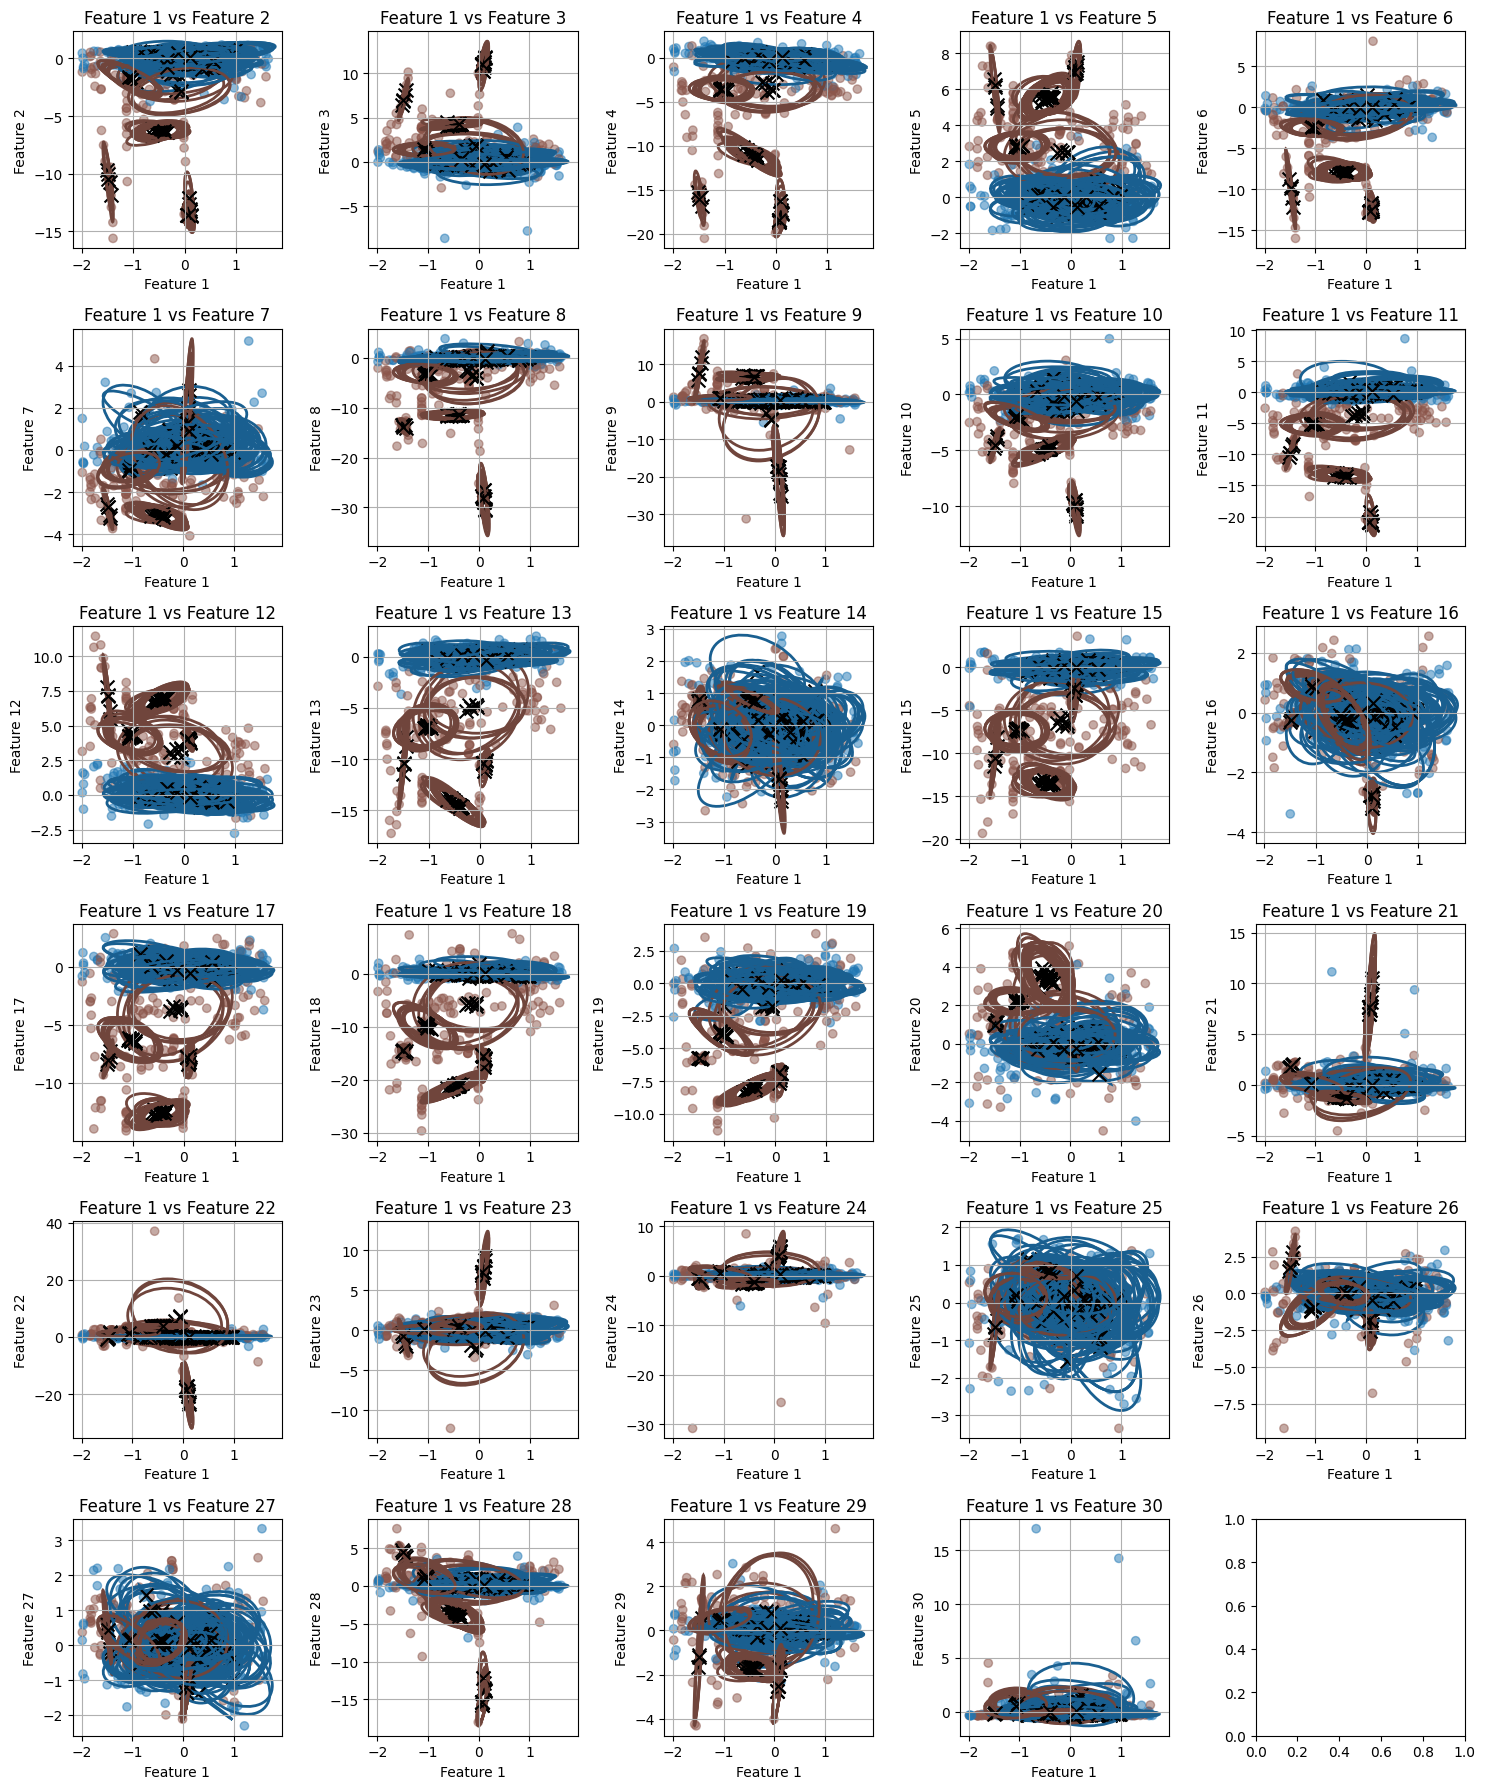

All Rounds Completed. Metrics Collected:
Round 1: Metrics: {'accuracy': 0.4864864864864865, 'precision': 0.48299319727891155, 'recall': 1.0, 'f1_score': 0.6513761467889908}, ROC AUC: 0.9242729101884032
Round 2: Metrics: {'accuracy': 0.48986486486486486, 'precision': 0.48464163822525597, 'recall': 1.0, 'f1_score': 0.6528735632183907}, ROC AUC: 0.9250503018108652
Round 3: Metrics: {'accuracy': 0.49324324324324326, 'precision': 0.4863013698630137, 'recall': 1.0, 'f1_score': 0.6543778801843319}, ROC AUC: 0.9254161331626122
Round 4: Metrics: {'accuracy': 0.8986486486486487, 'precision': 0.9, 'recall': 0.8873239436619719, 'f1_score': 0.8936170212765958}, ROC AUC: 0.9413983903420522
Round 5: Metrics: {'accuracy': 0.9087837837837838, 'precision': 0.967479674796748, 'recall': 0.8380281690140845, 'f1_score': 0.8981132075471698}, ROC AUC: 0.9608560453630877
Round 6: Metrics: {'accuracy': 0.8817567567567568, 'precision': 0.8496732026143791, 'recall': 0.9154929577464789, 'f1_score': 0.8813559322033

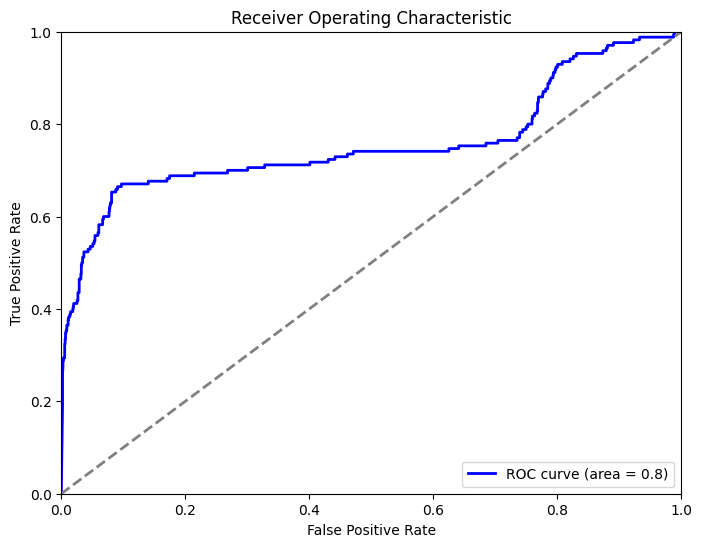

Test Metrics: {'accuracy': 0.8374384236453202, 'precision': 0.3549382716049383, 'recall': 0.6764705882352942, 'f1_score': 0.46558704453441296}
Test ROC AUC: 0.7572457318553281


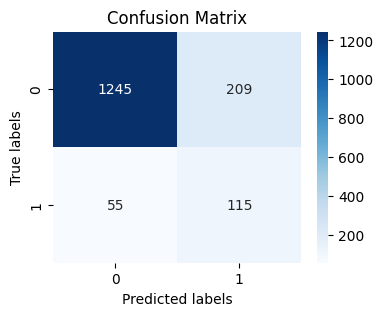

Evolving has been enabled.
Evolving has been disabled.


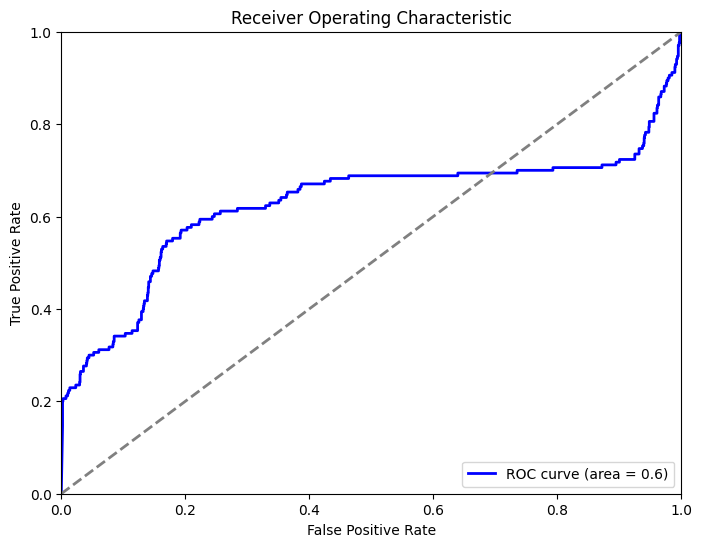

Test Metrics: {'accuracy': 0.5252463054187192, 'precision': 0.14011976047904193, 'recall': 0.6882352941176471, 'f1_score': 0.2328358208955224}
Test ROC AUC: 0.6262501011408689


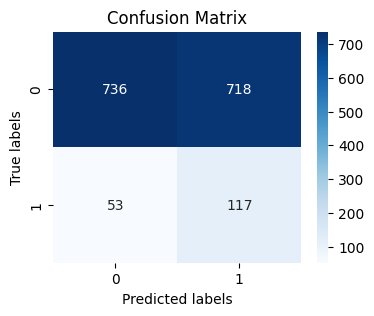

Evolving has been enabled.
Evolving has been disabled.


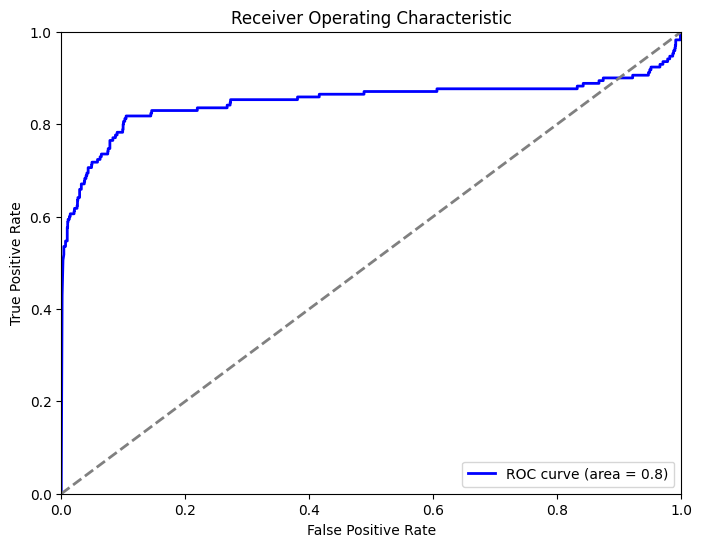

Test Metrics: {'accuracy': 0.8522167487684729, 'precision': 0.4, 'recall': 0.8235294117647058, 'f1_score': 0.5384615384615384}
Test ROC AUC: 0.8498907678614777


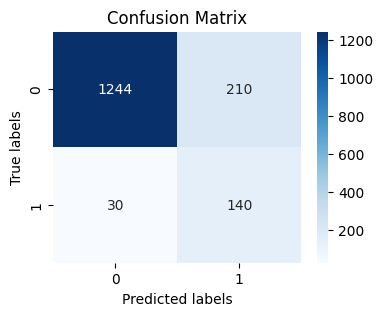

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 26
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 51
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 78
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 74
Evolving has been disabled.


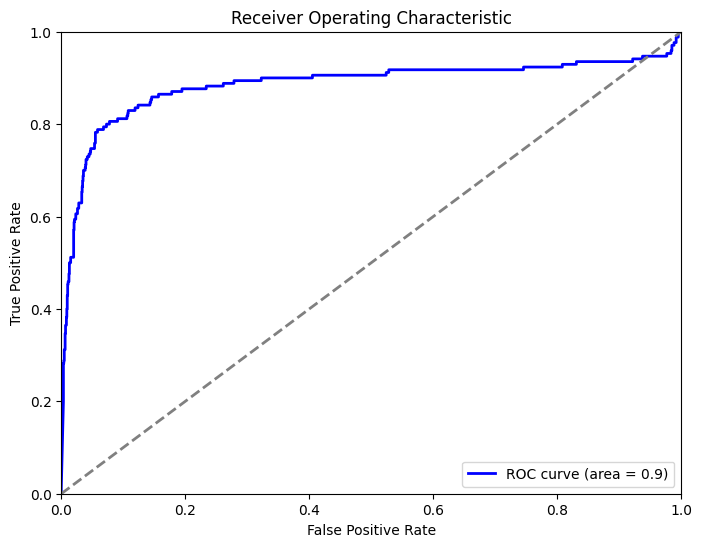

Test Metrics: {'accuracy': 0.8023399014778325, 'precision': 0.33184855233853006, 'recall': 0.8764705882352941, 'f1_score': 0.481421647819063}
Test ROC AUC: 0.8849785581357714


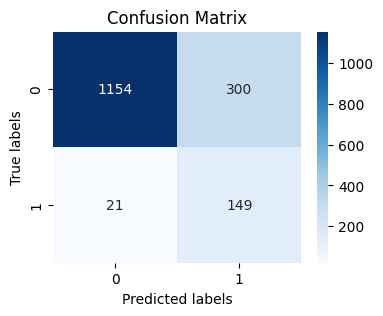

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 1 ---

--- Communication Round 2 ---
Evolving has been enabled.
Evolving has been disabled.


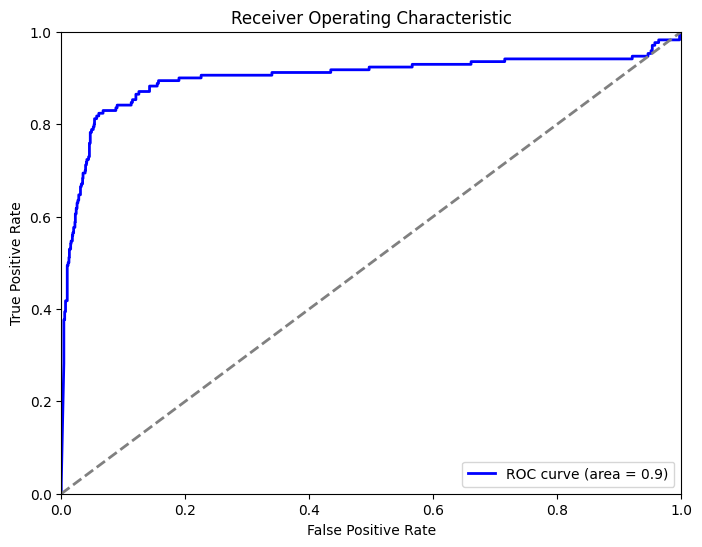

Test Metrics: {'accuracy': 0.7155172413793104, 'precision': 0.25666666666666665, 'recall': 0.9058823529411765, 'f1_score': 0.39999999999999997}
Test ROC AUC: 0.9009628610729024


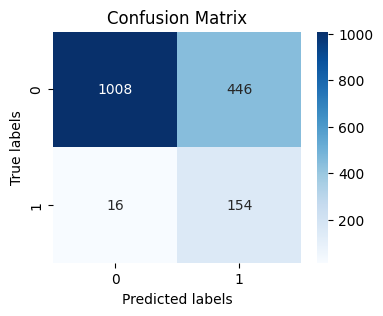

Evolving has been enabled.
Evolving has been disabled.


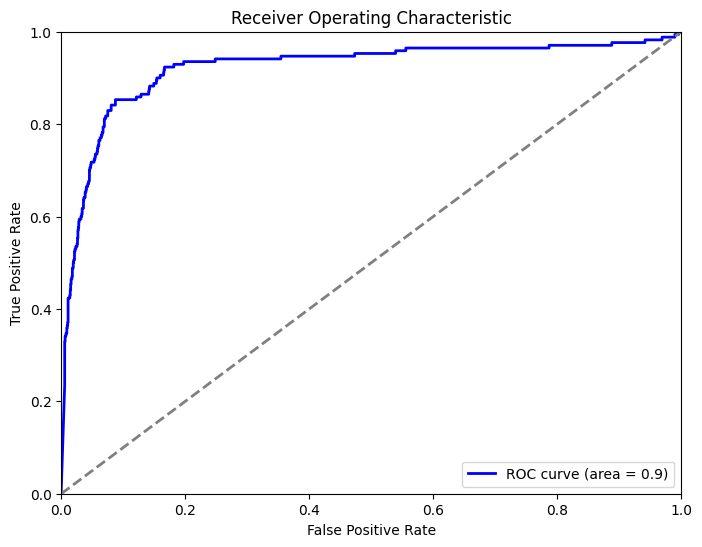

Test Metrics: {'accuracy': 0.6841133004926109, 'precision': 0.24132730015082957, 'recall': 0.9411764705882353, 'f1_score': 0.3841536614645858}
Test ROC AUC: 0.9219556598430294


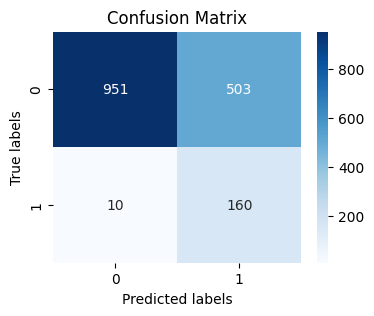

Evolving has been enabled.
Evolving has been disabled.


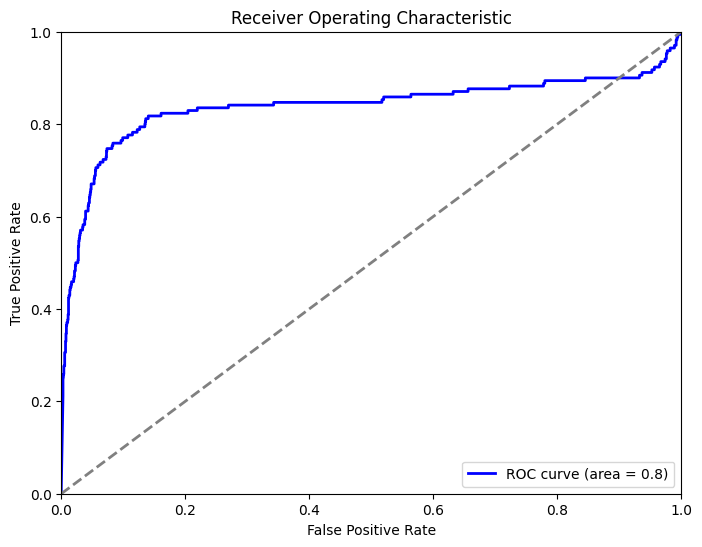

Test Metrics: {'accuracy': 0.728448275862069, 'precision': 0.25673249551166966, 'recall': 0.8411764705882353, 'f1_score': 0.39339752407152684}
Test ROC AUC: 0.8379622137713408


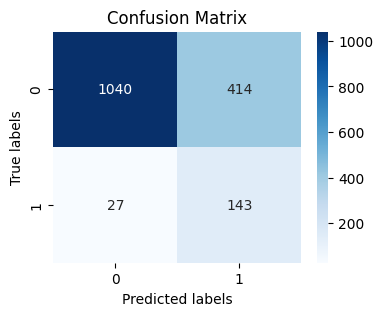

Updating agreggated model with client 1
Number of agreggated clusters after transfer = 73
Number of federated clusters after merging = 0
Updating agreggated model with client 2
Number of agreggated clusters after transfer = 141
Number of federated clusters after merging = 0
Updating agreggated model with client 3
Number of agreggated clusters after transfer = 181
Number of federated clusters after merging = 0
Updating federated model with agreggated model
Number of federated clusters after transfer = 147
Evolving has been disabled.


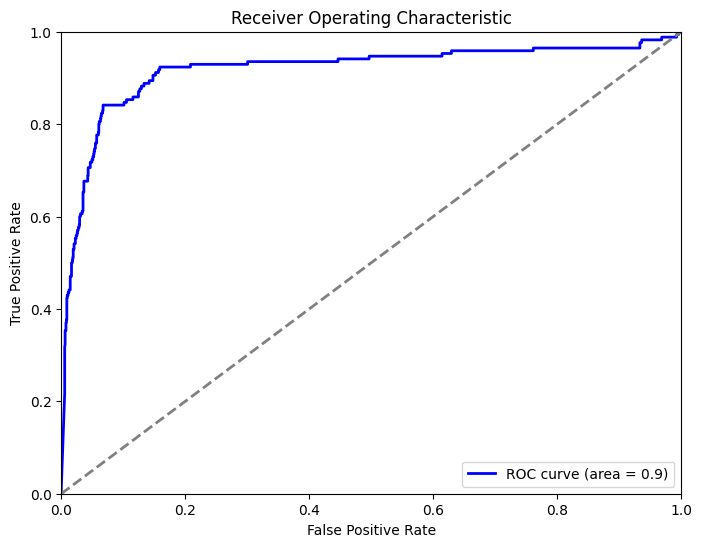

Test Metrics: {'accuracy': 0.7112068965517241, 'precision': 0.2576985413290113, 'recall': 0.9352941176470588, 'f1_score': 0.4040660736975857}
Test ROC AUC: 0.9176409903713894


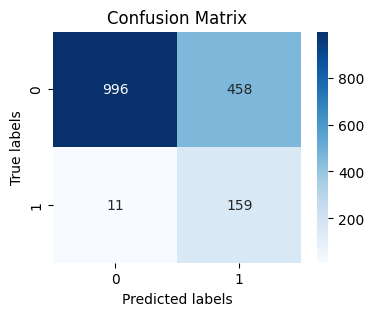

Returning updated model to client 1
Returning updated model to client 2
Returning updated model to client 3
--- End of Round 2 ---

--- Communication Round 3 ---
Evolving has been enabled.
Evolving has been disabled.


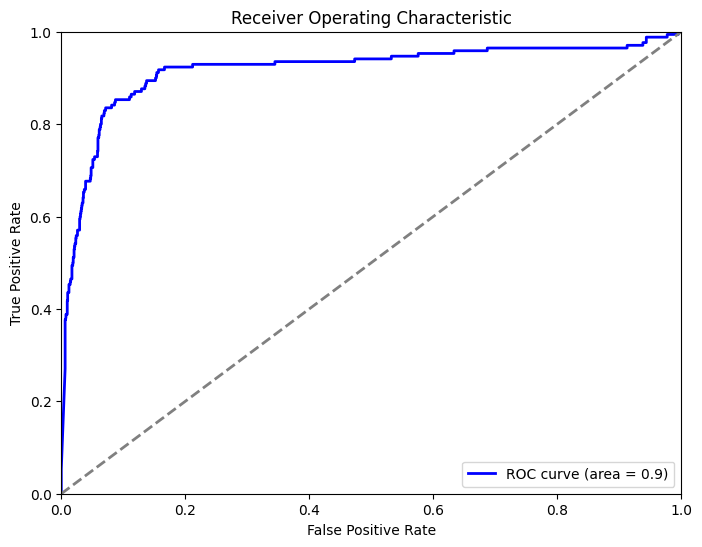

Test Metrics: {'accuracy': 0.6847290640394089, 'precision': 0.2409090909090909, 'recall': 0.9352941176470588, 'f1_score': 0.3831325301204819}
Test ROC AUC: 0.9175297354154867


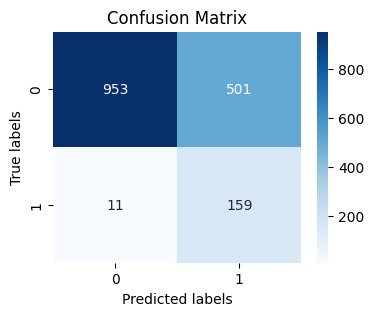

Evolving has been enabled.


In [11]:
# List of client counts and data configuration indices
client_counts = [3, 10]
data_config_indices = [1,2, 3]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 10
experiments = []
# Running the experiment
for num_clients in client_counts:
    for data_config_index in data_config_indices:
        if data_config_index == 1:
            proportion = 1
            data_partitioned = balance_dataset(data, proportion)
            X = data_partitioned.iloc[:, :-1].values
            y = data_partitioned.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 
        if data_config_index == 2:
            proportion = 10
            data_partitioned = balance_dataset(data, proportion)
            X = data_partitioned.iloc[:, :-1].values
            y = data_partitioned.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 
        if data_config_index == 3:
            X = data.iloc[:, :-1].values
            y = data.iloc[:, -1].values
            client_train, test_data, all_data = prepare_dataset(X, y, num_clients, smote = False) 

        display_dataset_split(client_train, test_data)

        print(f"Running experiment with {num_clients} clients and data configuration {data_config_index}")
        metrics = run_experiment(num_clients, num_rounds, client_train, test_data)
        experiments.append(metrics)

In [ ]:
print("All Rounds Completed. Metrics Collected:")
for metric in metrics:
    print(f"Round {metric['round']}: Metrics: {metric['binary']}, ROC AUC: {metric['roc_auc']}")
    print(f"                         Weighted: {metric['weighted']}")

In [ ]:
'''
for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        #print(f"Number of client {client_idx + 1} clusters before merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        #client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} after merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        federated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)

print(f"Number of clusters after transfer = {federated_model.c}")
'''

In [ ]:
'''
federated_model.federal_agent.federated_merging()
federated_model.removal_mech.removal_mechanism()
print(f"Number of clusters after merging = {federated_model.c}")
'''

In [ ]:

'''
print(f"\nTesting federated model")   

all_scores, pred_max, _ = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data, "binary")
print(f"Test Metrics: {metrics}")
roc_auc = calculate_roc_auc(all_scores, test_data)
print(f"Test ROC AUC: {roc_auc}")

plot_confusion_matrix(pred_max, test_data)
'''

In [ ]:

'''
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix values
tn = 135
fn = 10
tp = 132
fp = 19

# Creating the confusion matrix
y_true = [0]*tn + [1]*fn + [1]*tp + [0]*fp  # 0 for negative class, 1 for positive class
y_pred = [0]*(tn+fn) + [1]*(fp+tp)  # Predictions

# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(accuracy, precision, recall, f1)
'''